##Notebook to explore the Coadded image 33,15
<p>Sergio Daniel Hernandez Charpak</p>
<p>June 6th 2016</p>

In [1]:
%pylab inline
from sklearn import linear_model
import cv2
from math import exp
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from astropy.io import fits
import pickle
from PIL import Image
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
path_fits_image = './Fits/33,15_NO_Transient.fits'
real_coad_list = fits.open(path_fits_image)

As it is a .fits file, we open it and ask to see its information.

In [3]:
real_coad_list.info()

Filename: ./Fits/33,15_NO_Transient.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      17   ()              
1                ImageHDU        33   (1200, 1200)   float32   
2                ImageHDU        46   (1200, 1200)   int16   
3                ImageHDU        33   (1200, 1200)   float32   
4                BinTableHDU     40   19R x 7C     [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
5                BinTableHDU     43   2R x 7C      [1J, 1J, 1J, 1K, 2J, 2J, 1D]   
6                BinTableHDU     51   4R x 9C      [2D, 2D, 4D, 72A, 72A, 1D, 72A, 72A, 72A]   
7                BinTableHDU     54   1R x 10C     [1J, 1J, 1J, 1K, 2J, 2J, 1J, 1K, 1J, 1D]   
8                BinTableHDU     20   1R x 2C      [1J, 2D]   
9                BinTableHDU     28   1R x 4C      [2J, 2J, 4J, 4J]   
10               BinTableHDU     27   4R x 3C      [6D, 2D, 2D]   
11               BinTableHDU     27   4R x 3C      [2J, 2J, 729D]   
12               BinTableHD

The first three elements are images. Then we have 10 tables.

In [4]:
n_images = 3
real_coad_data_1 = real_coad_list[1].data
real_coad_data_2 = real_coad_list[2].data
real_coad_data_3 = real_coad_list[3].data
print shape(real_coad_data_1)
print shape(real_coad_data_2)
print shape(real_coad_data_3)

(1200, 1200)
(1200, 1200)
(1200, 1200)


<matplotlib.colorbar.Colorbar instance at 0x7f8752d44cf8>

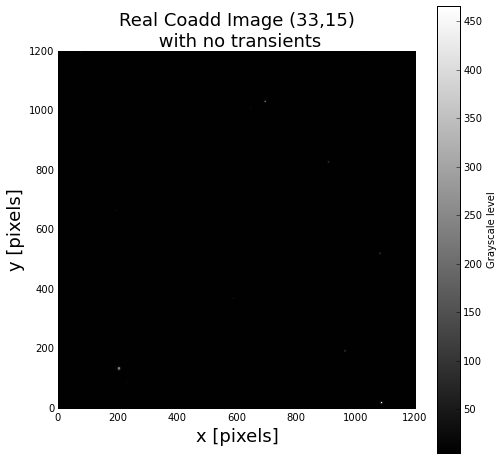

In [5]:
fig = plt.figure(figsize = (8,8))
plt.imshow(real_coad_data_1, origin='lower', cmap='gray')
plt.title("Real Coadd Image (33,15) \n with no transients", fontsize=18)
plt.xlabel("x [pixels]", fontsize=18)
plt.ylabel("y [pixels]", fontsize=18)
plt.colorbar(label="Grayscale level")

In [6]:
plt.close(fig)

<matplotlib.colorbar.Colorbar instance at 0x7f8752bd4b48>

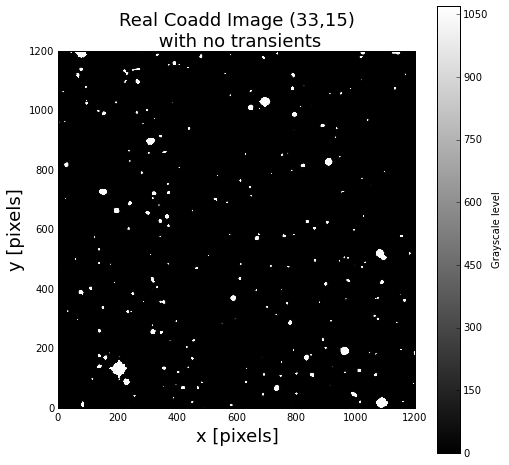

In [7]:
fig = plt.figure(figsize = (8,8))
plt.imshow(real_coad_data_2, origin='lower', cmap='gray')
plt.title("Real Coadd Image (33,15) \n with no transients", fontsize=18)
plt.xlabel("x [pixels]", fontsize=18)
plt.ylabel("y [pixels]", fontsize=18)
plt.colorbar(label="Grayscale level")

In [8]:
plt.close(fig)

<matplotlib.colorbar.Colorbar instance at 0x7f8752a9d248>

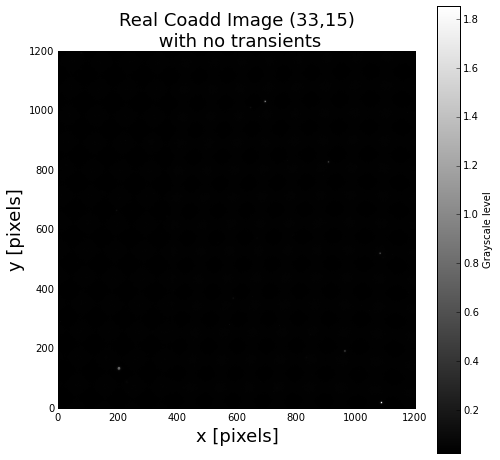

In [9]:
fig = plt.figure(figsize = (8,8))
plt.imshow(real_coad_data_3, origin='lower', cmap='gray')
plt.title("Real Coadd Image (33,15) \n with no transients", fontsize=18)
plt.xlabel("x [pixels]", fontsize=18)
plt.ylabel("y [pixels]", fontsize=18)
plt.colorbar(label="Grayscale level")

In [10]:
plt.close(fig)

The first and third images seem to be alike. Second one is int(16) semms binary. Second one seems to be the masks for the sources. As at the moment I'm not sure with which one work, I will simply use the function getdata from fits and work with its result. 

In [11]:
coadd_image = fits.getdata(path_fits_image)

<matplotlib.colorbar.Colorbar instance at 0x7f8751b69050>

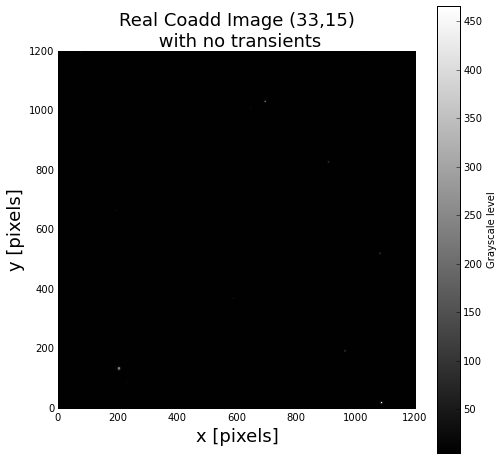

In [12]:
fig = plt.figure(figsize = (8,8))
plt.imshow(coadd_image, origin='lower', cmap='gray')
plt.title("Real Coadd Image (33,15) \n with no transients", fontsize=18)
plt.xlabel("x [pixels]", fontsize=18)
plt.ylabel("y [pixels]", fontsize=18)
plt.colorbar(label="Grayscale level")

In [13]:
plt.close(fig)

In [14]:
exp = real_coad_data_1 - coadd_image

In [15]:
print exp

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


We will work with this one

In [16]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return np.exp( -(((x-mu)/(sigma))**2.0)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
   
    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    
    return array(kernel2d)

def get_correct_PSF_representation(PSF, image):
    size_e = len(image) - len(PSF)
    PSF_e = np.pad(PSF, ((size_e/2,0),(size_e/2,0)), mode='constant')
    PSF_e = np.pad(PSF_e, ((0,size_e/2),(0,size_e/2)), mode='constant')
    PSF_e = fft.fftshift(PSF_e)
    return PSF_e

In [17]:
# Auxiliary functions to calculate beta
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

def get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N):
    max_iter_beta = 10000 # maximum number of iterations for the fit
    beta_epsilon = 0.001 # minimum distance for convergence of the fit
    epsilon = 0.001 # avoids division by zero
    beta = 1
    gamma_prime = 0

    beta_converges = False
    num_iter = 0

    while not beta_converges and num_iter < max_iter_beta:
        num_iter = num_iter + 1
        denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
        fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
        fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
        D_n = ifft2(fourier_D_n)
        D_r = ifft2(fourier_D_r)
    
        # Here, they select pixels which are one (really three) sigma above the image noise
        # We don't do that
    
        prev_beta = beta
    
        # The fit we are using ignores imaginary parts, so we fit the squares instead 
        beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
        if abs(beta - prev_beta) < beta_epsilon:
            beta_converges = True
    return beta

In [18]:
# Auxiliary functions to calculate S
def get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
    fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
    fourier_S = fourier_S/denom
    S = ifft2(fourier_S)
    return real(S)

In [19]:
# Auxiliary functions to calculate D
def get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    denom = sqrt(denom)
    fourier_D = (F_r)*fourier_PSF_r*fourier_N
    fourier_D = fourier_D - (F_n)*fourier_PSF_n*fourier_R
    fourier_D = fourier_D/denom
    D = ifft2(fourier_D)
    return real(D)

In [20]:
# Auxiliary functions to print candidates
def print_candidates_min(S, num_sigma):
    sigma_S = std(S)
    candidates_min = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) < ( num_sigma*sigma_S):
                candidates_min[i][j] = 255
    candidates_min  = np.abs(candidates_min - 255)
    fig = plt.figure(figsize = (14,14))
    plt.imshow(candidates_min, origin='lower', cmap="Greys_r")
    candidates_min = measure.label(candidates_min)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_min)):
        y = str(average(np.where(candidates_min == (i + 1))[0]))
        x = str(average(np.where(candidates_min == (i + 1))[1]))
        #cross on the candidate

        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (minimum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")
# Auxiliary functions to print candidates
def print_candidates_max(S, num_sigma):
    sigma_S = std(S)
    candidates_max = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) > ( num_sigma*sigma_S):
                candidates_max[i][j] = 255
    fig = plt.figure(figsize = (14,14))
    plt.imshow(candidates_max, origin='lower', cmap="Greys_r")
    candidates_max = measure.label(candidates_max)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_max)):
        y = str(average(np.where(candidates_max == (i + 1))[0]))
        x = str(average(np.where(candidates_max == (i + 1))[1]))
        #cross on the candidate
        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (maximum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")

In [21]:
path_fits_image = './Fits/33,15_NO_Transient.fits'

In [22]:
R = fits.getdata(path_fits_image)
N = fits.getdata('./Fits/Real/S+0/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [23]:
# Estimating noise parameters
# Because we have no mask to differentiate background and sources in this case, we take noise 
# as the 10% least intense pixels of the images
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(N))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 3.67199
sigma_n: 4.04183


In [24]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 7.58028
sigma_PSF_n: 10.1536


<matplotlib.colorbar.Colorbar instance at 0x7f874fe8ecb0>

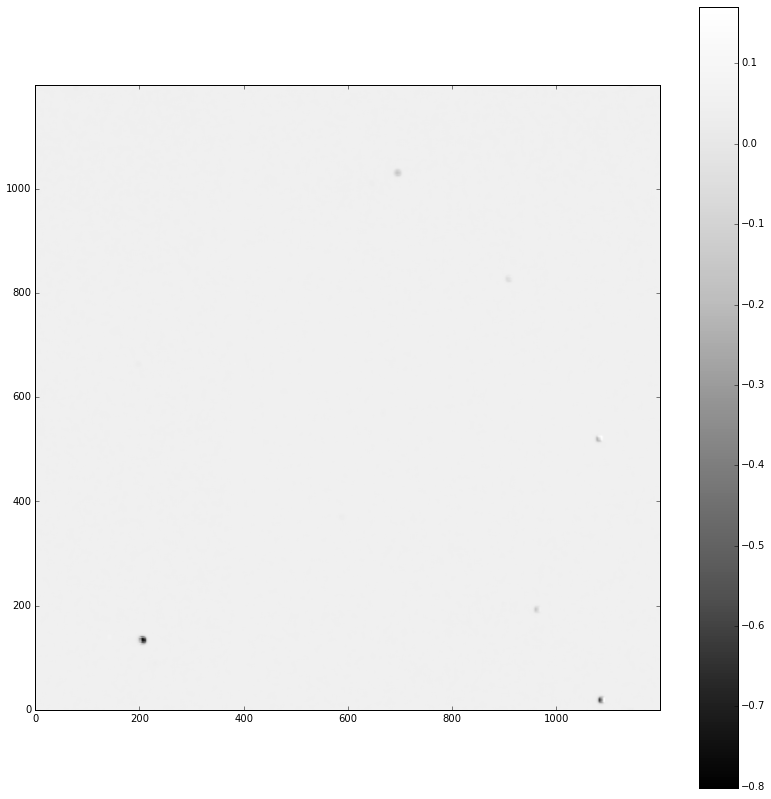

In [25]:
# Calculating S
S = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(S, origin='lower', cmap="Greys_r")
plt.colorbar()

Candidate (minimum analysis) 1: (1081.63636364, 18.5454545455)
Candidate (minimum analysis) 2: (207.454545455, 133.340909091)
Candidate (minimum analysis) 3: (205.5, 140.0)


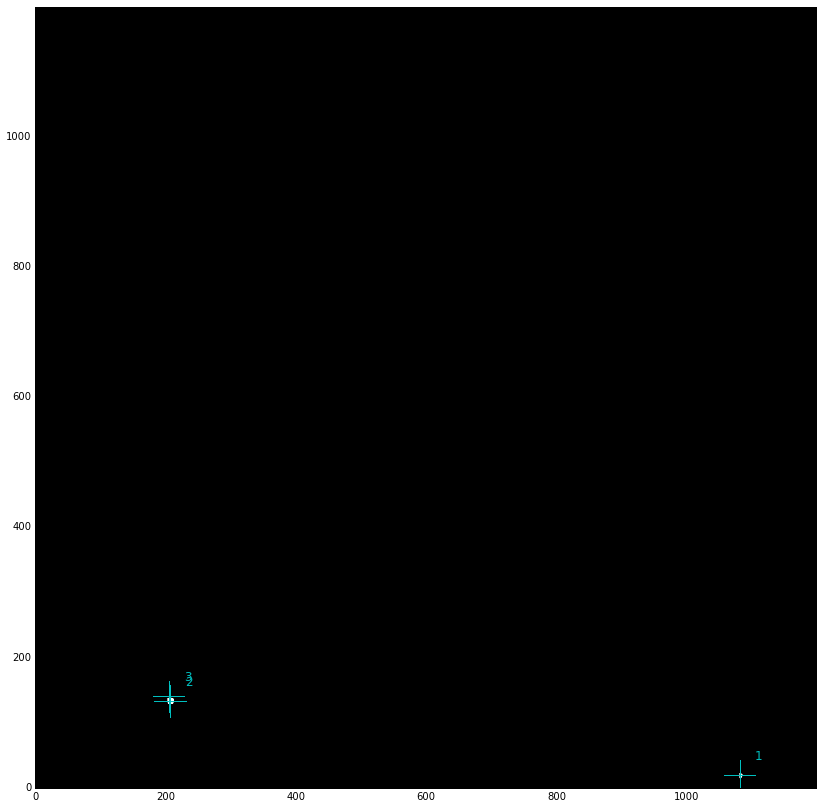

In [26]:
print_candidates_min(S, 50)

Candidate (maximum analysis) 1: (1081.63636364, 18.5454545455)
Candidate (maximum analysis) 2: (207.454545455, 133.340909091)
Candidate (maximum analysis) 3: (205.5, 140.0)


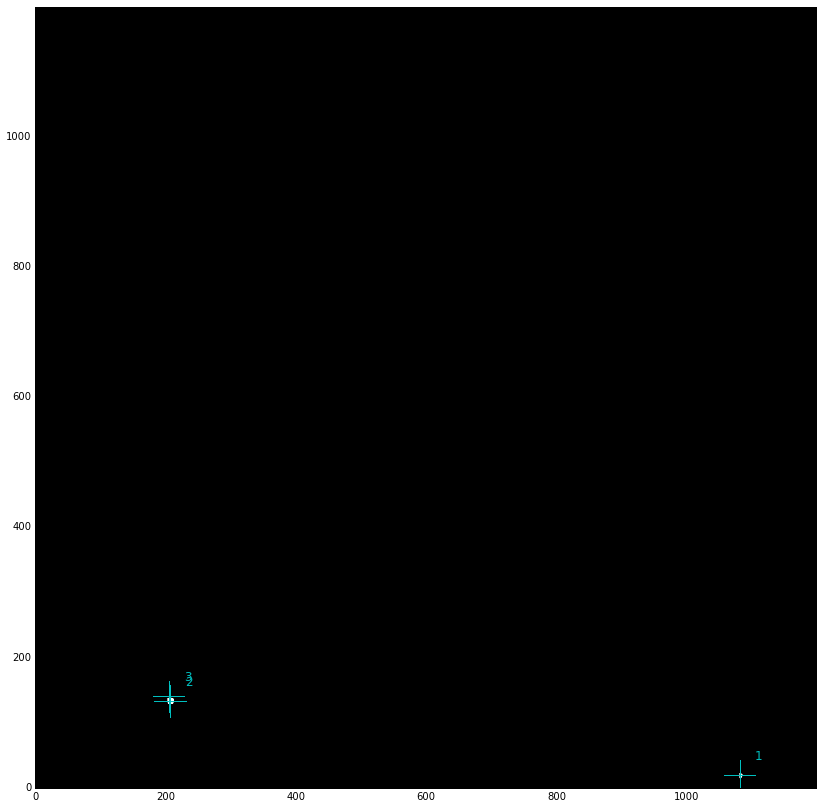

In [27]:
print_candidates_max(S, 50)

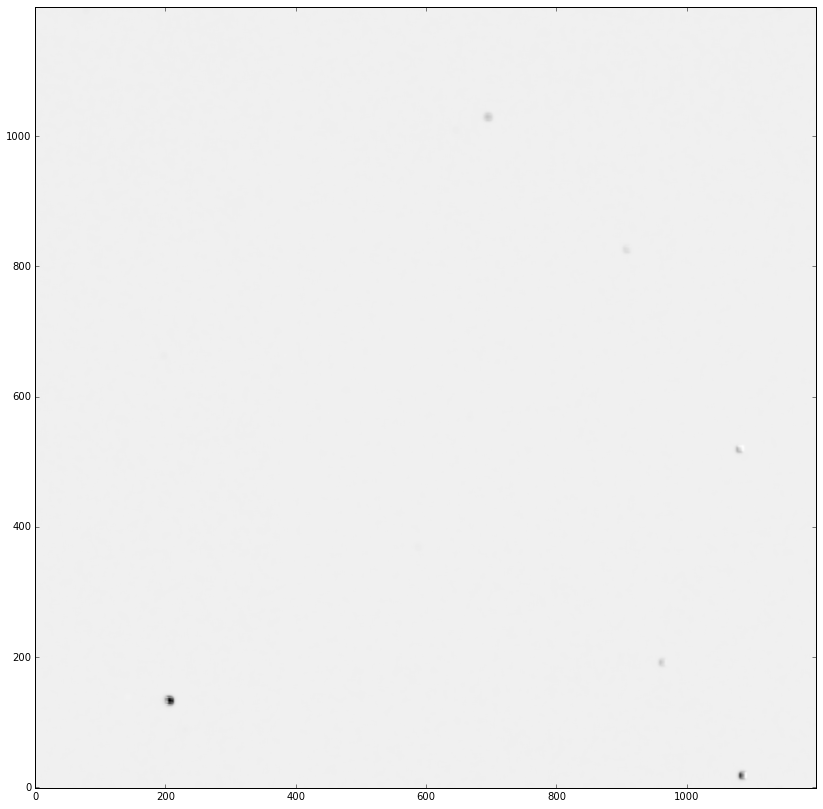

In [28]:
# Calculating D
D = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(D, origin='lower', cmap="Greys_r")

In [29]:
R = fits.getdata(path_fits_image)
N = fits.getdata('./Fits/Real/S+1/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [30]:
# Estimating noise parameters
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(R))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 3.67199
sigma_n: 3.47929


In [31]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 7.58028
sigma_PSF_n: 16.2016


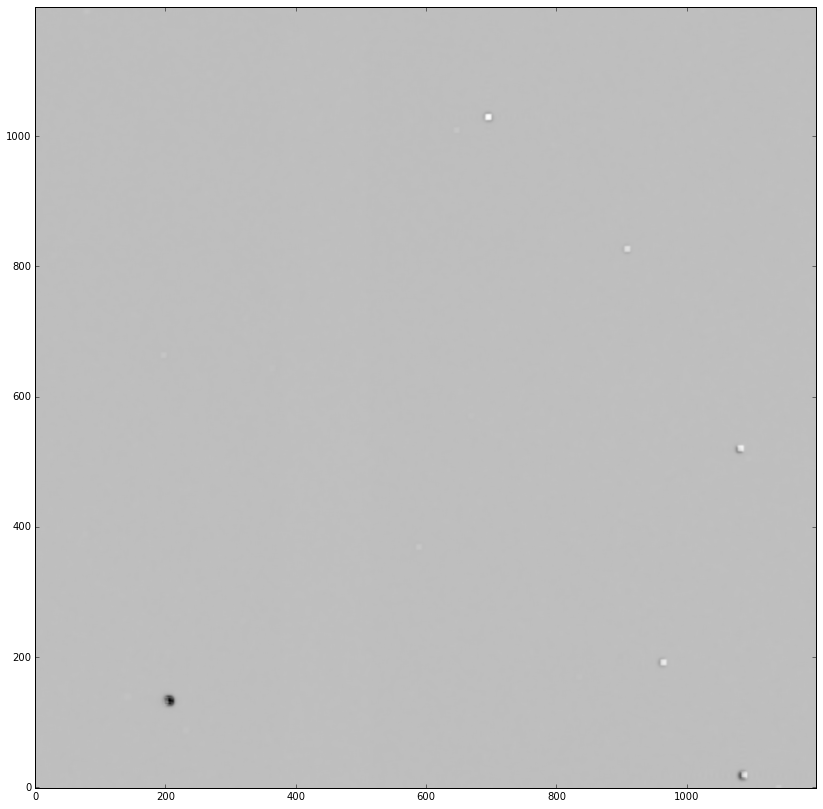

In [32]:
# Calculating S
S = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(S, origin='lower', cmap="Greys_r")

Candidate (minimum analysis) 1: (1139.7, 1.98)
Candidate (minimum analysis) 2: (1088.51282051, 20.1666666667)
Candidate (minimum analysis) 3: (390.0, 46.0)
Candidate (minimum analysis) 4: (231.25, 88.3125)
Candidate (minimum analysis) 5: (206.5, 133.5)
Candidate (minimum analysis) 6: (141.144329897, 139.453608247)
Candidate (minimum analysis) 7: (834.428571429, 170.057142857)
Candidate (minimum analysis) 8: (964.092592593, 192.305555556)
Candidate (minimum analysis) 9: (588.445783133, 368.963855422)
Candidate (minimum analysis) 10: (75.9565217391, 388.739130435)
Candidate (minimum analysis) 11: (1094.11111111, 504.611111111)
Candidate (minimum analysis) 12: (1083.22834646, 521.582677165)
Candidate (minimum analysis) 13: (490.0, 520.0)
Candidate (minimum analysis) 14: (668.555555556, 570.472222222)
Candidate (minimum analysis) 15: (362.8125, 642.9375)
Candidate (minimum analysis) 16: (196.906666667, 663.093333333)
Candidate (minimum analysis) 17: (907.990384615, 826.490384615)
Candidate

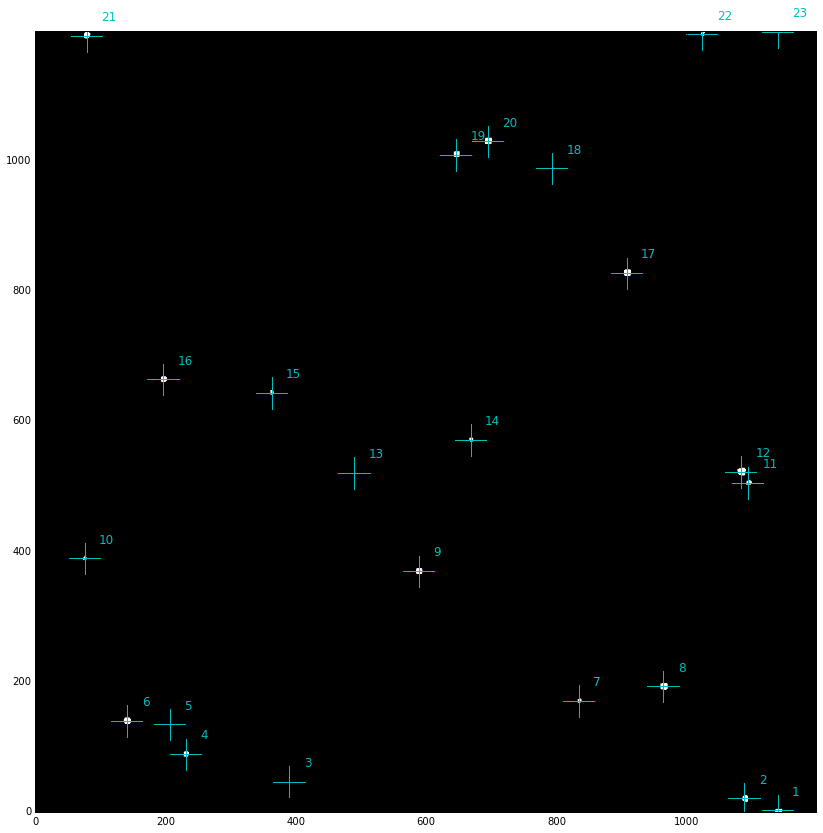

In [33]:
print_candidates_min(S, 50)

Candidate (maximum analysis) 1: (1139.7, 1.98)
Candidate (maximum analysis) 2: (1088.51282051, 20.1666666667)
Candidate (maximum analysis) 3: (390.0, 46.0)
Candidate (maximum analysis) 4: (231.25, 88.3125)
Candidate (maximum analysis) 5: (206.5, 133.5)
Candidate (maximum analysis) 6: (141.144329897, 139.453608247)
Candidate (maximum analysis) 7: (834.428571429, 170.057142857)
Candidate (maximum analysis) 8: (964.092592593, 192.305555556)
Candidate (maximum analysis) 9: (588.445783133, 368.963855422)
Candidate (maximum analysis) 10: (75.9565217391, 388.739130435)
Candidate (maximum analysis) 11: (1094.11111111, 504.611111111)
Candidate (maximum analysis) 12: (1083.22834646, 521.582677165)
Candidate (maximum analysis) 13: (490.0, 520.0)
Candidate (maximum analysis) 14: (668.555555556, 570.472222222)
Candidate (maximum analysis) 15: (362.8125, 642.9375)
Candidate (maximum analysis) 16: (196.906666667, 663.093333333)
Candidate (maximum analysis) 17: (907.990384615, 826.490384615)
Candidate

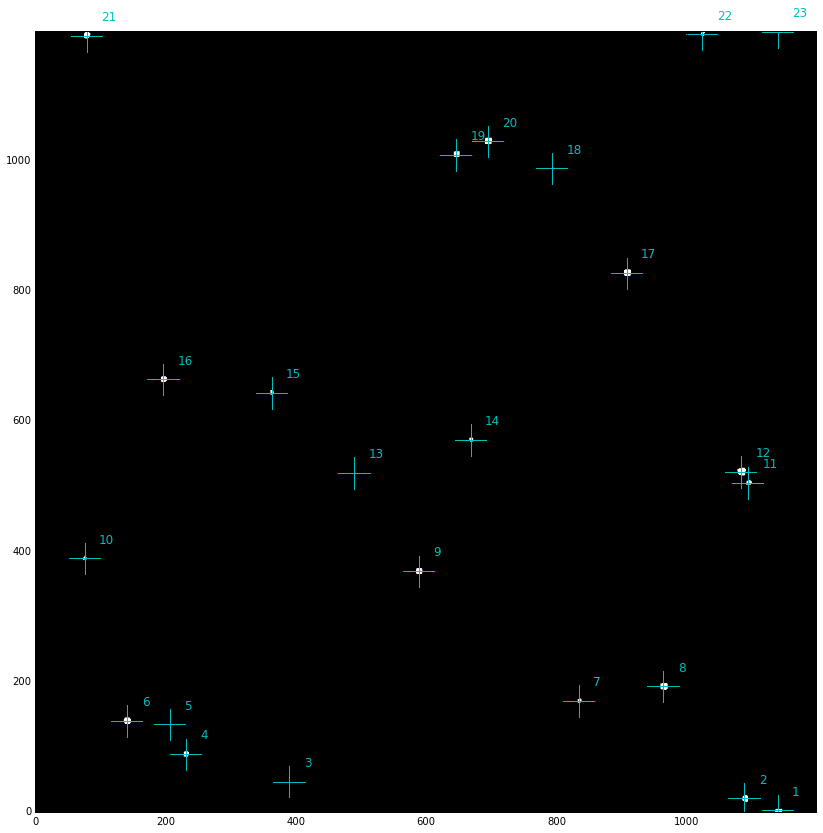

In [34]:
print_candidates_max(S, 50)

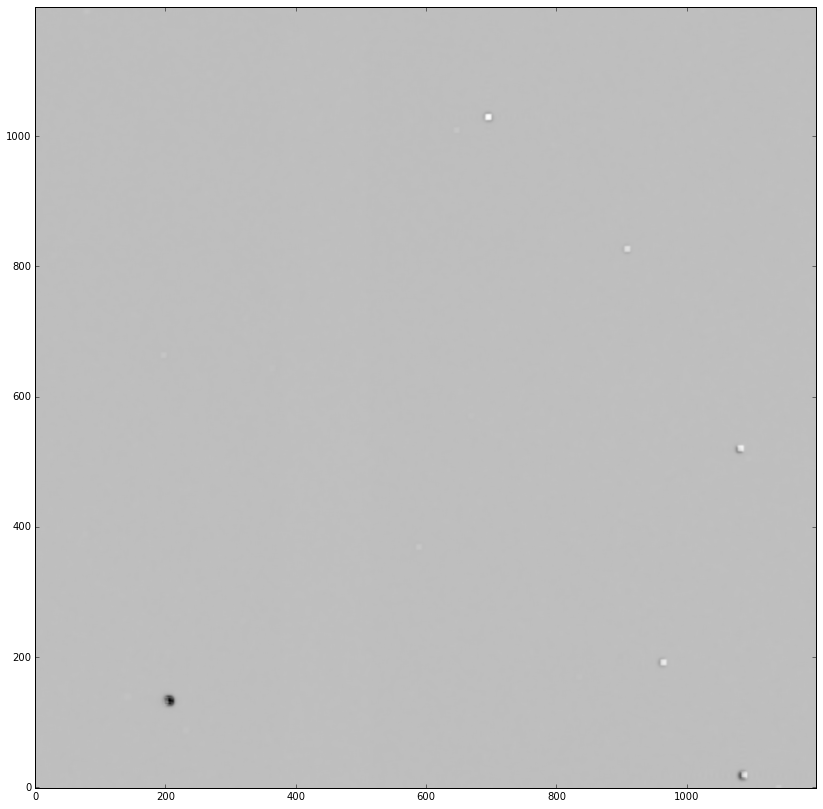

In [35]:
# Calculating D
D = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(D, origin='lower', cmap="Greys_r")

In [36]:
R = fits.getdata(path_fits_image)
N = fits.getdata('./Fits/Real/S-1/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [37]:
# Estimating noise parameters
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(R))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 3.67199
sigma_n: 3.43099


In [38]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 7.58028
sigma_PSF_n: 7.02189


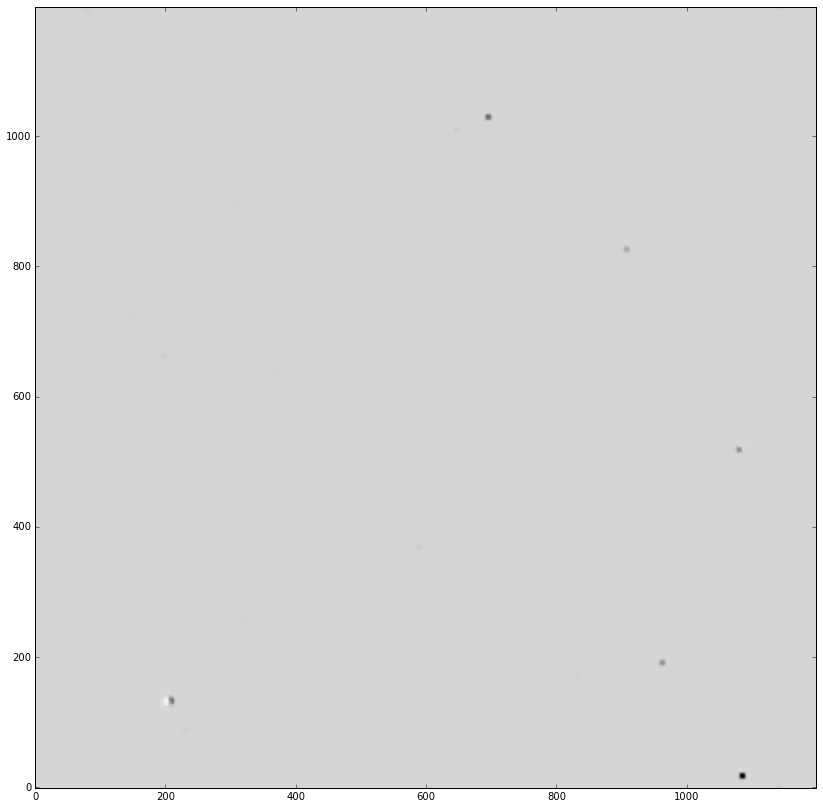

In [39]:
# Calculating S
S = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(S, origin='lower', cmap="Greys_r")

Candidate (minimum analysis) 1: (1084.42222222, 18.3111111111)
Candidate (minimum analysis) 2: (209.372093023, 133.697674419)
Candidate (minimum analysis) 3: (960.8, 191.6)
Candidate (minimum analysis) 4: (1078.4, 517.8)
Candidate (minimum analysis) 5: (694.654545455, 1028.30909091)


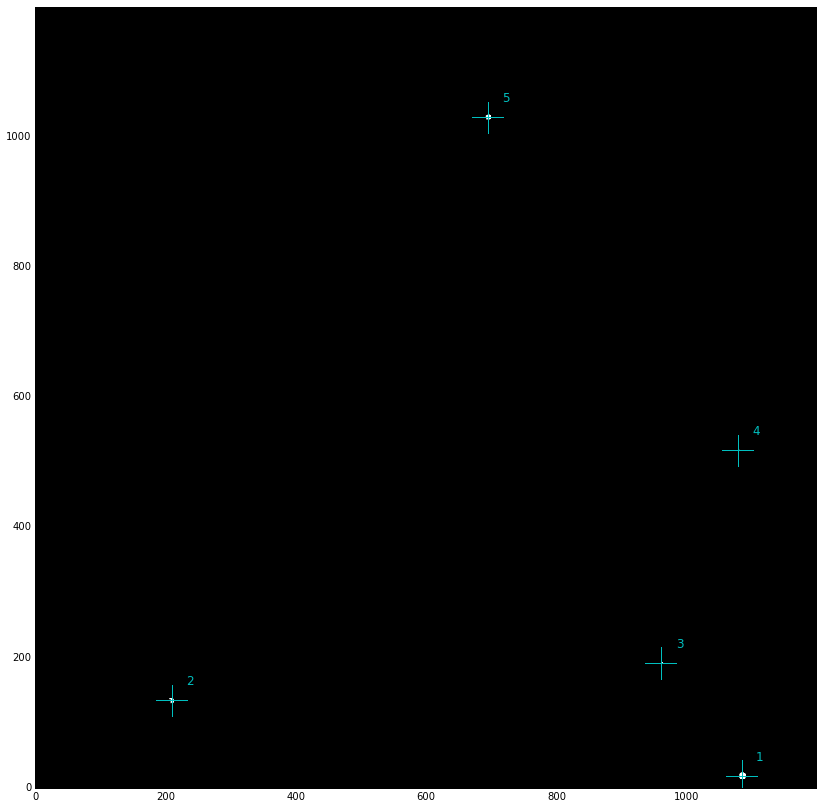

In [40]:
print_candidates_min(S, 50)

Candidate (maximum analysis) 1: (1084.42222222, 18.3111111111)
Candidate (maximum analysis) 2: (209.372093023, 133.697674419)
Candidate (maximum analysis) 3: (960.8, 191.6)
Candidate (maximum analysis) 4: (1078.4, 517.8)
Candidate (maximum analysis) 5: (694.654545455, 1028.30909091)


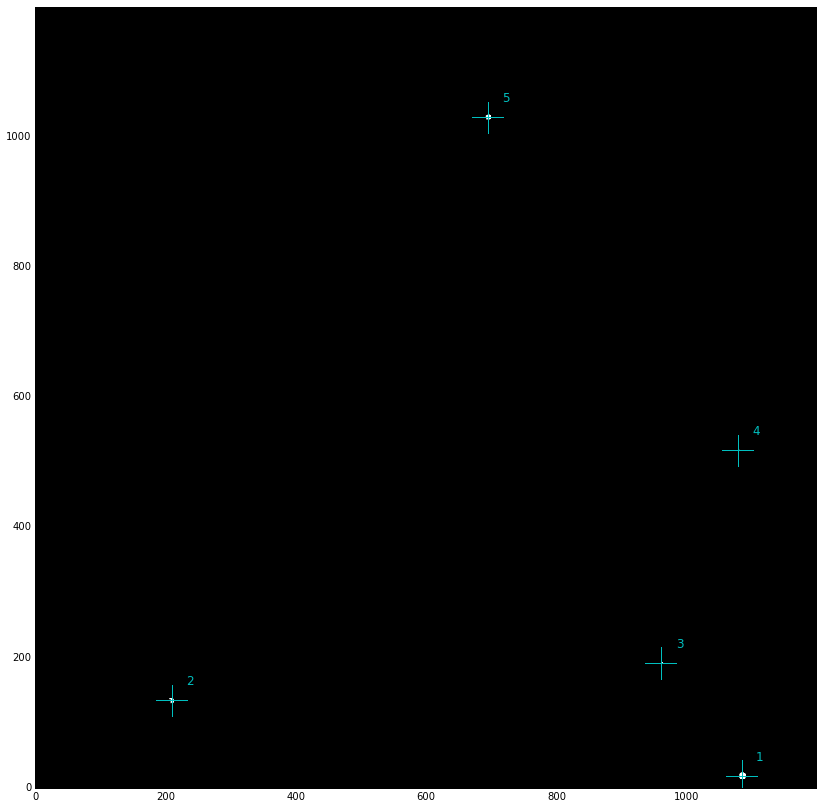

In [41]:
print_candidates_max(S, 50)

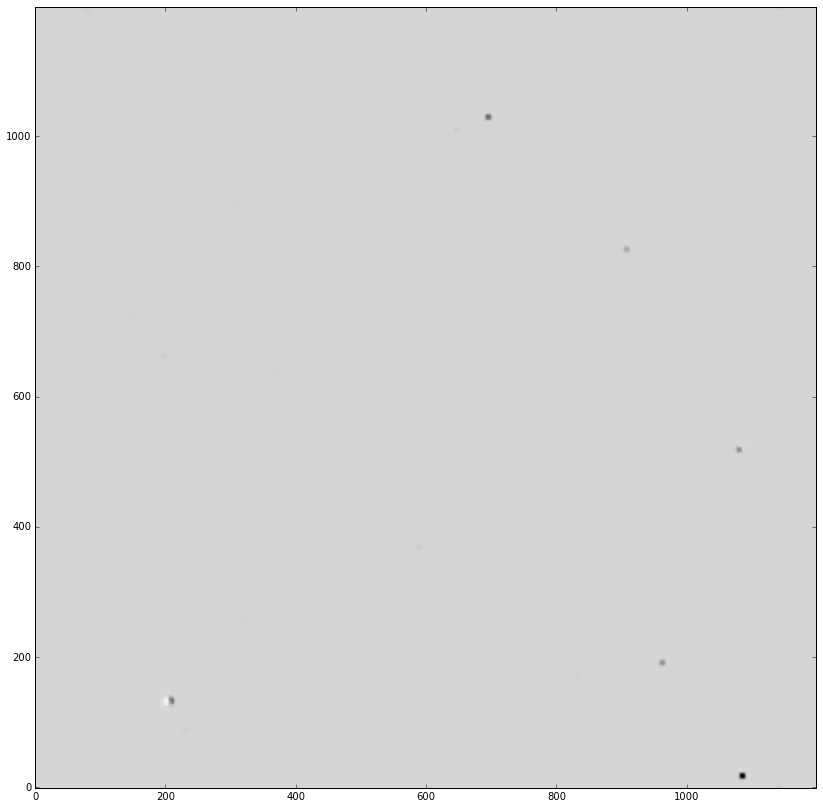

In [42]:
# Calculating D
D = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (14,14))
plt.imshow(D, origin='lower', cmap="Greys_r")